In [1]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import signal
from scipy import fftpack
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
def pelton_res_f(freq, res0, eta, tau, c):
    iwtc = (1j * 2 * np.pi * freq*tau) ** c
    return res0*(1.-eta*(1.-1./(1. + iwtc)))

def pelton_con_f(freq, sig8, eta, tau, c):
    iwtc = (1j * 2 * np.pi * freq*tau) ** c
    return sig8-sig8*(eta/(1.+(1.-eta)*iwtc))

def debye_con_t(times, con8, eta, tau):
    if any(time < 0 for time in times):
        raise ValueError("Time array must not be negative")
    if not all(times[i] <= times[i + 1] for i in range(len(times) - 1)):
        raise ValueError("Time array must be in ascending order")
    debye = np.zeros_like(times)
    ind_0 = (times == 0)
    debye[ind_0] = 1.0
    debye[~ind_0] = -eta/((1.0-eta)*tau)*np.exp(-times[~ind_0]/((1.0-eta)*tau))
    return con8*debye

def debye_con_t_intg(times, con8, eta, tau):
    if any(time < 0 for time in times):
        raise ValueError("Time array must not be negative")
    if not all(times[i] <= times[i + 1] for i in range(len(times) - 1)):
        raise ValueError("Time array must be in ascending order")
    return con8 *(1.0 -eta*(1. -np.exp(-times/((1.0-eta)*tau))))

def debye_res_t(times, res0, eta, tau):
    if any(time < 0 for time in times):
        raise ValueError("Time array must not be negative")
    if not all(times[i] <= times[i + 1] for i in range(len(times) - 1)):
        raise ValueError("Time array must be in ascending order")
    debye = np.zeros_like(times)
    res8 = res0 * (1.0 - eta)
    ind_0 = (times == 0)
    debye[ind_0] = res8 
    debye[~ind_0] = (res0-res8)/tau * np.exp(-times[~ind_0] / tau)
    return debye

def debye_res_t_intg(times, res0, eta, tau):
    if any(time < 0 for time in times):
        raise ValueError("Time array must not be negative")
    if not all(times[i] <= times[i + 1] for i in range(len(times) - 1)):
        raise ValueError("Time array must be in ascending order")
    res8 = res0 * (1.0 - eta)
    return res8 + (res8 - res0)*(np.exp(-times/tau) - 1.0)

def freq_symmetric(f):
    symmetric = np.zeros_like(f, dtype=complex)
    nstep = len(f)
    half_step = nstep // 2
    symmetric[:half_step] = f[:half_step]
    symmetric[half_step:] = f[:half_step].conj()[::-1]
    assert np.allclose(symmetric[:half_step].real, symmetric[half_step:].real[::-1])
    assert np.allclose(symmetric[:half_step].imag, -symmetric[half_step:].imag[::-1])
    return symmetric

In [3]:
log10frqend = 6
log10frqstrt = -2
log10step = 0.1
freq = 10**np.arange(log10frqstrt, log10frqend, log10step)
res0, eta, tau, c = 200, 0.5,  0.1, 1.
con8 = 1/(res0*(1-eta))
print(f"res0{res0:10.2e}, con8{con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}")


res0  2.00e+02, con8  1.00e-02, eta=   0.500, tau=  1.00e-01, c=   1.000


In [4]:
def plot_pelton(freq,res0=None, con8=None, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    if res0 is None and con8 is None:
        raise ValueError('Error: either res0 or con8 must be set')
    elif res0 is not None and con8 is not None:
        raise ValueError('Error: both sigma0 or sigmaInf are set')
    
    if con8 is None:
        fft_res_f = pelton_res_f(freq, res0, eta, tau, c)
        ax[0].set_title(f''' Resistivity form
            res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[0].semilogx(freq, fft_res_f.real, label='Real')
        ax[0].semilogx(freq, -fft_res_f.imag, label='-Imaginary')
        ax[0].semilogx(freq, np.abs(fft_res_f), label='Absolute Value')
        ax[0].set_ylim(bottom=0)
        # Phase plot (in degrees)
        ax[1].semilogx(freq, np.degrees(np.angle(fft_res_f)), label='Phase (degrees)')
        ax[1].invert_yaxis()

    if res0 is None:
        fft_f = pelton_con_f(freq, con8, eta, tau, c)
        ax[0].set_title(f''' Conductivity form
             con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[0].semilogx(freq, fft_f.real, label='Real')
        ax[0].semilogx(freq, fft_f.imag, label='Imaginary')
        ax[0].semilogx(freq, np.abs(fft_f), label='Absolute Value')
        ax[0].set_ylim(bottom=0)
        # Phase plot (in degrees)
        ax[1].semilogx(freq, np.degrees(np.angle(fft_con_f)), label='Phase (degrees)')

    # Shared x-axis label and vertical line
    for a in ax:
        # a.axvline(1/(tau * np.pi), color='k', linestyle='--',
        #         label=r'$\frac{1}{2\pi\tau}$')
        a.axvline(1/(tau), color='k', linestyle='--',
                 label=r'$1/\tau$')
#                label=r'$\frac{1}{\tau}$')
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    ax[1].set_ylabel('Phase [Degrees]')
    return ax 

In [5]:
res0min, res0max = 1.0e-3, 1.0e6
log10res0min, log10res0max = np.log10(res0min), np.log10(res0max)
con8min, con8max = 1.0e-6, 1.0e3
log10con8min, log10con8max = np.log10(con8min), np.log10(con8max)
etamin, etamax = 0, 0.99
taumin, taumax = 1.0e-6, 1.0
log10taumin, log10taumax = np.log10(taumin), np.log10(taumax)
cmin, cmax = 0., 1.0
res0_default, eta_default, tau_default, c_default = 200, 0.5,  0.1, 1.
con8_default = 1 / (res0_default * (1 - eta_default))


In [6]:
#  Widget for the main function
def plot_colecole_widget(conductivity_or_resistivity, res0=None, con8=None, eta=None, tau=None, c=None):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    nfreq = 2**16
    freqcen = 1/(tau)
    freqend = freqcen * nfreq**0.5
    freqstep = freqend/nfreq
    freq = np.linspace(freqstep,freqend,nfreq) 

    if conductivity_or_resistivity == "Resistivity":
        plot_pelton(freq=freq,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        plot_pelton(freq=freq,con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

# ToggleButtons for selecting resistivity or conductivity
conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
    button_style='info',
)

# Define sliders
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
# Use interactive display based on the toggle selection
def update_sliders(mode):
    if mode == "Resistivity":
        display(res0_slider, eta_slider, tau_slider, c_slider)
    else:
        display(con8_slider, eta_slider, tau_slider, c_slider)

ipywidgets.widgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
ipywidgets.widgets.interactive(
    plot_colecole_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

interactive(children=(ToggleButtons(button_style='info', description='Mode:', options=('Resistivity', 'Conduct…

# Fourier Transform

In [7]:
## define parameters
res0, eta, tau, c = 200, 0.5,  0.1, 1.
con8 = 1/(res0*(1-eta))
print(f'res0{res0:10.2e}, con8{con8:10.2e}, eta{eta:8.3f}, tau{tau:10.2e}, c{c:8.3f}')

res0  2.00e+02, con8  1.00e-02, eta   0.500, tau  1.00e-01, c   1.000


In [8]:
## get frequency regarding the tau
nfreq = 2**16
freqcen = 1/(tau)
freqend = freqcen * nfreq**0.5
freqstep = freqend/nfreq
freq_tau = np.arange(0,freqend,freqstep) 
print(f'log2(len(freq)): {np.log2(len(freq_tau))}')
print(f'step size      : {freqstep}')

log2(len(freq)): 16.0
step size      : 0.0390625


In [9]:
## get the time domain
fft_f = pelton_con_f(freq_tau, con8, eta, tau, c)
fft_f = freq_symmetric(fft_f)
fft_data = np.fft.ifft(fft_f).real *freqend
print(f"FFT result min    :{np.min(fft_data):10.2e}, max:{np.max(fft_data):10.2e}")
times_tau = np.fft.fftfreq(len(fft_data), d=freqstep)
time_step = times_tau[1] - times_tau[0]
fft_data = fft_data[times_tau >= 0]
times_tau = times_tau[times_tau >= 0]
fft_data_tau = fft_data
fft_data_tau_intg = np.cumsum(fft_data_tau)*time_step
print(f"Time step size    :{time_step:10.2e}")
print(f"log2(len(times_tau)): {np.log2(len(times_tau))}")
print(f"con(0):              {fft_data_tau[0]*time_step:10.2e}")

FFT result min    : -1.08e-01, max:  2.55e+01
Time step size    :  3.91e-04
log2(len(times_tau)): 15.0
con(0):                9.98e-03


In [10]:
## get window
times=times_tau
windows_strt = np.zeros_like(times)
windows_end = np.zeros_like(times)
dt = np.diff(times)
windows_strt[1:] = times[:-1] + dt / 2
windows_end[:-1] = times[1:] - dt / 2
windows_strt[0] = times[0] - dt[0] / 2
windows_end[-1] = times[-1] + dt[-1] / 2
print(f"windows_strt min  :{np.min(windows_strt):10.2e}, max:{np.max(windows_strt):10.2e}")
print(f"windows_end min   :{np.min(windows_end):10.2e}, max:{np.max(windows_end):10.2e}")
print(f'len(window)       :{len(windows_strt)}')
print(f"log2(len(window)) :{np.log2(len(windows_strt))}")

windows_strt min  : -1.95e-04, max:  1.28e+01
windows_end min   :  1.95e-04, max:  1.28e+01
len(window)       :32768
log2(len(window)) :15.0


In [11]:
## get frequency regarding the tau and time
log2min=-8
log2max=8        
freqstep = 1/tau*(2**np.floor(np.min(
    np.r_[log2min,np.log2(tau/windows_end[-1] -eps)]
)))
freqend = 1/tau*(2**np.ceil(np.max(
    np.r_[log2max, np.log2(2*tau/min(np.diff(times)) +eps )]
)))
freq_tau_time = np.arange(0,freqend,freqstep)
print(f'log2(len(freq_tau_time)): {np.log2(len(freq_tau_time))}')
print(freqend)
print(freq_tau_time[-1]+freq_tau_time[1]-freq_tau_time[0])

log2(len(freq_tau_time)): 18.0
10240.0
10240.0


In [12]:
fft_f = pelton_con_f(freq_tau_time, con8, eta, tau, c)
fft_f = freq_symmetric(fft_f)
fft_data = np.fft.ifft(fft_f).real *freqend
print(f"FFT result min    :{np.min(fft_data):10.2e}, max:{np.max(fft_data):10.2e}")
times_tau_time = np.fft.fftfreq(len(fft_data), d=freqstep)
time_step = times_tau_time[1] - times_tau_time[0]
fft_data = fft_data[times_tau_time >= 0]
times_tau_time = times_tau_time[times_tau_time >= 0]
fft_data_tau_time = fft_data
fft_data_tau_time_intg = np.cumsum(fft_data_tau_time)*time_step
print(f"Time step size           : {time_step:10.2e}")
print(f"log2(len(times_tau_time)): {np.log2(len(times_tau_time))}")
print(f"con(0):                  : {fft_data_tau_time[0]*time_step:10.2e}")

FFT result min    : -1.09e-01, max:  1.02e+02
Time step size           :   9.77e-05
log2(len(times_tau_time)): 17.0
con(0):                  :   1.00e-02


In [13]:
## Apply windowing
times= times_tau_time
data= fft_data_tau_time
start_indices = np.searchsorted(times, windows_strt, side='left')
end_indices = np.searchsorted(times, windows_end, side='right')
# Compute windowed averages
window_data = np.zeros_like(windows_strt, dtype=float)
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    if start < end:  # Ensure there are elements in the window
        window_data[i] = np.mean(data[start:end])


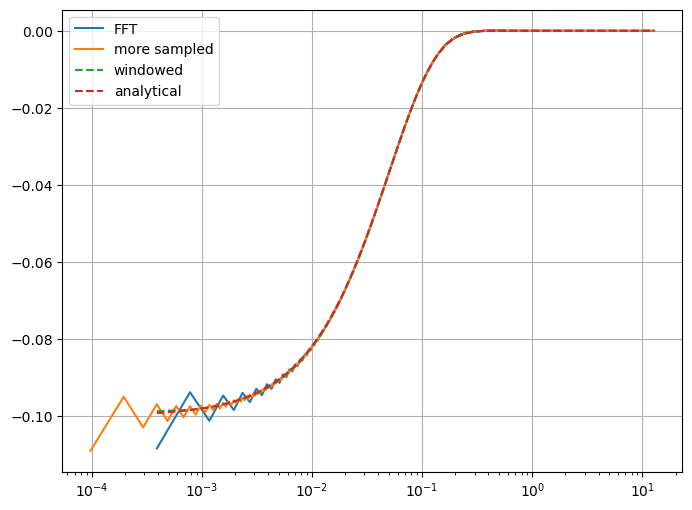

In [14]:
fig = plt.figure(figsize=(8, 6))
# plt.plot(np.r_[0,0],np.r_[0,fft_data_tau[0]],'-',label='FFT  t=0')
# plt.plot(np.r_[0,0],np.r_[0,fft_data_tau_time[0]],'--',label='more sampled')
# plt.plot(np.r_[0,0],np.r_[0,window_data[0]],'-')
# plt.plot(np.r_[0,0],np.r_[0,debye_con_t(times=times_tau[0],con8=con8,eta=eta,tau=tau),'--')

plt.semilogx(times_tau[1:]     ,fft_data_tau[1:],'-',label='FFT')
plt.semilogx(times_tau_time[1:],fft_data_tau_time[1:],'-',label='more sampled')
plt.semilogx(times_tau[1:]     ,window_data[1:],'--',label='windowed')
plt.semilogx(times_tau[1:]     ,debye_con_t(times=times_tau[1:],con8=con8,eta=eta,tau=tau),'--',label='analytical')

plt.legend()
plt.grid()  

In [15]:
## Apply windowing
times= times_tau_time
data= fft_data_tau_time_intg
start_indices = np.searchsorted(times, windows_strt, side='left')
end_indices = np.searchsorted(times, windows_end, side='right')
# Compute windowed averages
window_data = np.zeros_like(windows_strt, dtype=float)
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    if start < end:  # Ensure there are elements in the window
        window_data[i] = np.mean(data[start:end])


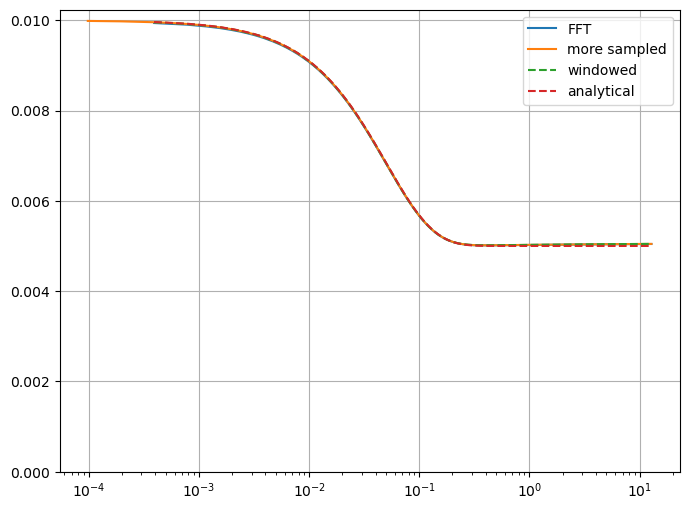

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.semilogx(times_tau[1:]     ,fft_data_tau_intg[1:],'-',label='FFT')
plt.semilogx(times_tau_time[1:],fft_data_tau_time_intg[1:],'-',label='more sampled')
plt.semilogx(times_tau[1:]     ,window_data[1:],'--',label='windowed')
plt.semilogx(times_tau[1:]     ,debye_con_t_intg(times=times_tau[1:],con8=con8,eta=eta,tau=tau),'--',label='analytical')
plt.ylim(bottom=0)
plt.legend()
plt.grid()  

# Test for resistivity as well

In [17]:
## get frequency regarding the tau
nfreq = 2**16
freqcen = 1/(tau)
freqend = freqcen * nfreq**0.5
freqstep = freqend/nfreq
freq_tau = np.arange(0,freqend,freqstep) 
print(f'log2(len(freq)): {np.log2(len(freq_tau))}')
print(f'step size      : {freqstep}')

log2(len(freq)): 16.0
step size      : 0.0390625


In [18]:
## get the time domain
fft_f = pelton_res_f(freq=freq_tau, res0=res0, eta=eta, tau=tau, c=c)
fft_f = freq_symmetric(fft_f)
fft_data = np.fft.ifft(fft_f).real *freqend
print(f"FFT result min    :{np.min(fft_data):10.2e}, max:{np.max(fft_data):10.2e}")
times_tau = np.fft.fftfreq(len(fft_data), d=freqstep)
time_step = times_tau[1] - times_tau[0]
fft_data = fft_data[times_tau >= 0]
times_tau = times_tau[times_tau >= 0]
fft_data_tau = fft_data
fft_data_tau_intg = np.cumsum(fft_data_tau)*time_step
print(f"Time step size    :{time_step:10.2e}")
print(f"log2(len(times_tau)): {np.log2(len(times_tau))}")
print(f"res(0):              {fft_data_tau[0]*time_step:10.2e}")

FFT result min    : -8.56e+01, max:  2.57e+05
Time step size    :  3.91e-04
log2(len(times_tau)): 15.0
res(0):                1.00e+02


In [19]:
## get window
times=times_tau
windows_strt = np.zeros_like(times)
windows_end = np.zeros_like(times)
dt = np.diff(times)
windows_strt[1:] = times[:-1] + dt / 2
windows_end[:-1] = times[1:] - dt / 2
windows_strt[0] = times[0] - dt[0] / 2
windows_end[-1] = times[-1] + dt[-1] / 2
print(f"windows_strt min  :{np.min(windows_strt):10.2e}, max:{np.max(windows_strt):10.2e}")
print(f"windows_end min   :{np.min(windows_end):10.2e}, max:{np.max(windows_end):10.2e}")
print(f'len(window)       :{len(windows_strt)}')
print(f"log2(len(window)) :{np.log2(len(windows_strt))}")

windows_strt min  : -1.95e-04, max:  1.28e+01
windows_end min   :  1.95e-04, max:  1.28e+01
len(window)       :32768
log2(len(window)) :15.0


In [20]:
## get frequency regarding the tau and time
log2min=-8
log2max=8        
freqstep = 1/tau*(2**np.floor(np.min(
    np.r_[log2min,np.log2(tau/windows_end[-1] -eps)]
)))
freqend = 1/tau*(2**np.ceil(np.max(
    np.r_[log2max, np.log2(2*tau/min(np.diff(times)) +eps )]
)))
freq_tau_time = np.arange(0,freqend,freqstep)
print(f'log2(len(freq_tau_time)): {np.log2(len(freq_tau_time))}')
print(freqend)
print(freq_tau_time[-1]+freq_tau_time[1]-freq_tau_time[0])

log2(len(freq_tau_time)): 18.0
10240.0
10240.0


In [21]:
fft_f = pelton_res_f(freq=freq_tau_time, res0=res0, eta=eta, tau=tau, c=c)
fft_f = freq_symmetric(fft_f)
fft_data = np.fft.ifft(fft_f).real *freqend
print(f"FFT result min    :{np.min(fft_data):10.2e}, max:{np.max(fft_data):10.2e}")
times_tau_time = np.fft.fftfreq(len(fft_data), d=freqstep)
time_step = times_tau_time[1] - times_tau_time[0]
fft_data = fft_data[times_tau_time >= 0]
times_tau_time = times_tau_time[times_tau_time >= 0]
fft_data_tau_time = fft_data
fft_data_tau_time_intg = np.cumsum(fft_data_tau_time)*time_step
print(f"Time step size           : {time_step:10.2e}")
print(f"log2(len(times_tau_time)): {np.log2(len(times_tau_time))}")
print(f"res(0):                  : {fft_data_tau_time[0]*time_step:10.2e}")

FFT result min    : -8.56e+01, max:  1.02e+06
Time step size           :   9.77e-05
log2(len(times_tau_time)): 17.0
res(0):                  :   1.00e+02


In [22]:
## Apply windowing
times= times_tau_time
data= fft_data_tau_time
start_indices = np.searchsorted(times, windows_strt, side='left')
end_indices = np.searchsorted(times, windows_end, side='right')
# Compute windowed averages
window_data = np.zeros_like(windows_strt, dtype=float)
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    if start < end:  # Ensure there are elements in the window
        window_data[i] = np.mean(data[start:end])


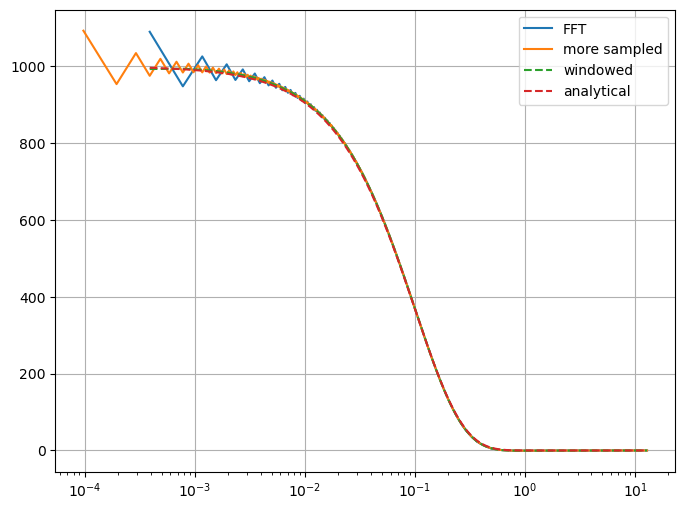

In [23]:
fig = plt.figure(figsize=(8, 6))
# plt.plot(np.r_[0,0],np.r_[0,fft_data_tau[0]],'-',label='FFT  t=0')
# plt.plot(np.r_[0,0],np.r_[0,fft_data_tau_time[0]],'--',label='more sampled')
# plt.plot(np.r_[0,0],np.r_[0,window_data[0]],'-')
# plt.plot(np.r_[0,0],np.r_[0,debye_con_t(times=times_tau[0],con8=con8,eta=eta,tau=tau),'--')

plt.semilogx(times_tau[1:]     ,fft_data_tau[1:],'-',label='FFT')
plt.semilogx(times_tau_time[1:],fft_data_tau_time[1:],'-',label='more sampled')
plt.semilogx(times_tau[1:]     ,window_data[1:],'--',label='windowed')
plt.semilogx(times_tau[1:]     ,debye_res_t(times=times_tau[1:],res0=res0,eta=eta,tau=tau),'--',label='analytical')

plt.legend()
plt.grid()  

In [24]:
## Apply windowing
times= times_tau_time
data= fft_data_tau_time_intg
start_indices = np.searchsorted(times, windows_strt, side='left')
end_indices = np.searchsorted(times, windows_end, side='right')
# Compute windowed averages
window_data = np.zeros_like(windows_strt, dtype=float)
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    if start < end:  # Ensure there are elements in the window
        window_data[i] = np.mean(data[start:end])


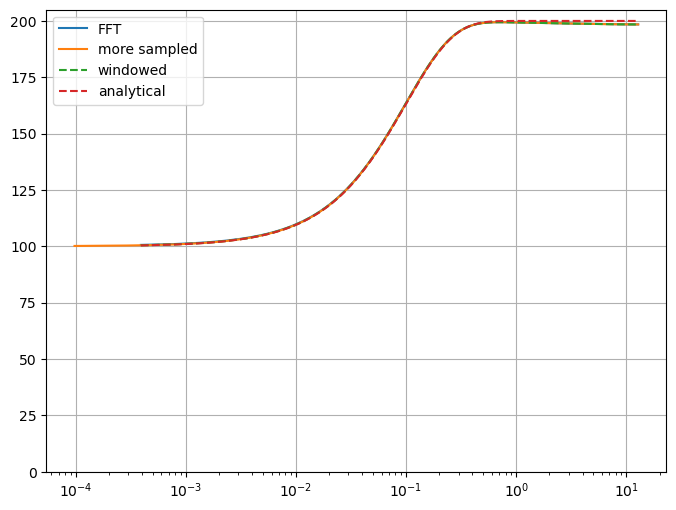

In [25]:
fig = plt.figure(figsize=(8, 6))
plt.semilogx(times_tau[1:]     ,fft_data_tau_intg[1:],'-',label='FFT')
plt.semilogx(times_tau_time[1:],fft_data_tau_time_intg[1:],'-',label='more sampled')
plt.semilogx(times_tau[1:]     ,window_data[1:],'--',label='windowed')
plt.semilogx(times_tau[1:]     ,debye_res_t_intg(times=times_tau[1:],res0=res0,eta=eta,tau=tau),'--',label='analytical')
plt.ylim(bottom=0)
plt.legend()
plt.grid()  

## Further work on analytical solution

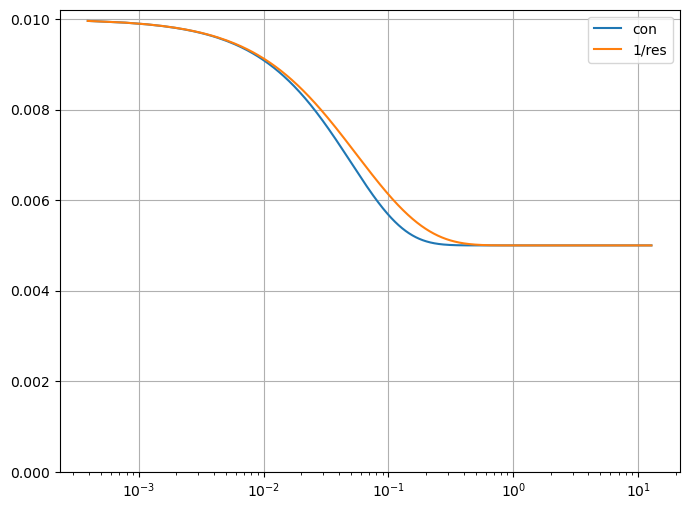

In [26]:
fig = plt.figure(figsize=(8, 6))
plt.semilogx(times_tau[1:]     ,debye_con_t_intg(times=times_tau[1:],con8=con8,eta=eta,tau=tau),label='con')
plt.semilogx(times_tau[1:]     ,1/debye_res_t_intg(times=times_tau[1:],res0=res0,eta=eta,tau=tau),label='1/res')
plt.ylim(bottom=0)
plt.legend()
plt.grid()  

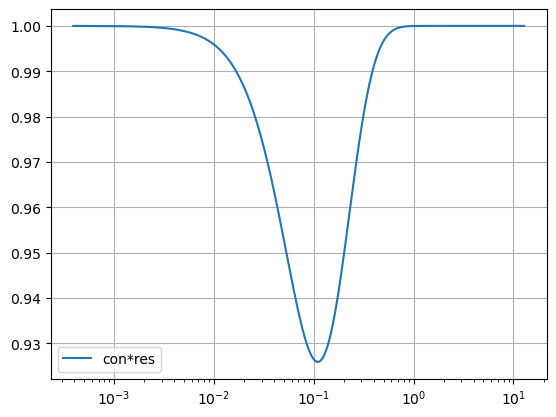

In [27]:
plt.semilogx(times_tau[1:]     ,
    debye_con_t_intg(times=times_tau[1:],con8=con8,eta=eta,tau=tau)
    *debye_res_t_intg(times=times_tau[1:],res0=res0,eta=eta,tau=tau),label='con*res')
plt.grid()
plt.legend()


# Test for InducedPolarization.py
# deep sea hydrothermal deposit model

In [28]:
from InducedPolarization import InducedPolarization as IP

In [29]:
#res0, eta, tau, c = 200, 0.5,  0.1, 1.
res0, eta, tau, c = 0.15, 0.3,  1e-3, 0.8
con8 = 1/(res0*(1-eta))
IPmodel = IP(con8=con8, res0=res0,eta=eta, tau=tau, c=c)

In [30]:
freq_tau = IPmodel.get_frequency_tau()
times_tau, data_tau = IPmodel.pelton_fft()
freq_tau_time = IPmodel.get_frequency_tau_times(times=times_tau)
times_tau_time, data_tau_time = IPmodel.pelton_fft()
IPmodel.get_windows(times=times_tau)
window_data = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time)

log2(freq) 16.0 considering tau
log2(freq) 18.0 considering tau and times


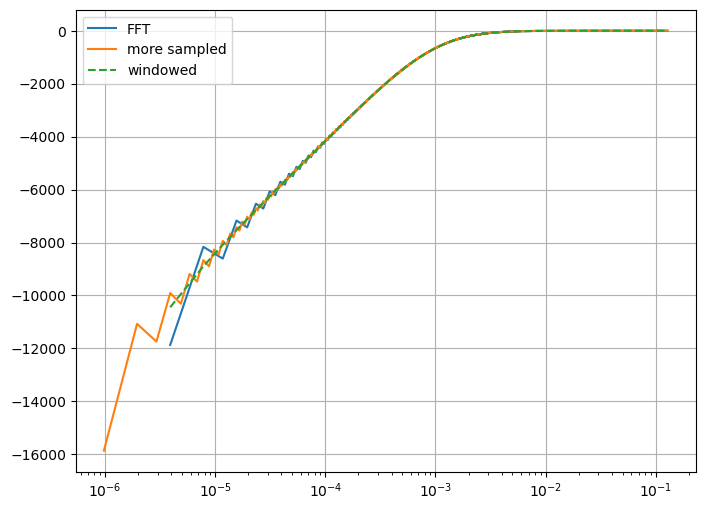

In [31]:
fig = plt.figure(figsize=(8, 6))
plt.semilogx(times_tau[1:]     ,data_tau[1:],'-',label='FFT')
plt.semilogx(times_tau_time[1:],data_tau_time[1:],'-',label='more sampled')
plt.semilogx(times_tau[1:]     ,window_data[1:],'--',label='windowed')
plt.legend()
plt.grid()  

# FFT with various c

In [32]:
def clc_fft(con_form=True, res0=None, con8=None, eta=None, tau=None, c=None):
    freq_tau=IPmodel.get_frequency_tau(tau=tau)
    times_tau, data_tau = IPmodel.pelton_fft(con_form=con_form, freq=freq_tau,
             con8=con8, res0=res0,eta=eta,tau=tau, c=c)
    freq_tau_time =IPmodel.get_frequency_tau_times(tau=tau, times=times_tau)
    times_tau_time, data_tau_time = IPmodel.pelton_fft(con_form=con_form
        , freq=freq_tau_time,con8=con8, res0=res0,eta=eta,tau=tau, c=c)
    timestep = times_tau_time[1] - times_tau_time[0]
    data_tau_time_intg = np.cumsum(data_tau_time)*timestep
    IPmodel.get_windows(times=times_tau)
    window_data = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time)
    window_data_intg = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time_intg)

    return times_tau, window_data, window_data_intg

In [33]:
times, data, data_intg= clc_fft(con_form=True,con8=con8,res0=res0, eta=eta, tau=tau, c=c)

log2(freq) 16.0 considering tau
log2(freq) 18.0 considering tau and times


In [34]:
def plot_fft(res0=None, con8=None, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2,1, figsize=(8, 6))
    
    if con8 is None:
        freq_tau=IPmodel.get_frequency_tau(tau=tau)
        times_tau, data_tau = IPmodel.pelton_fft(con_form=False, freq=freq_tau,
                con8=con8, res0=res0,eta=eta,tau=tau, c=c)
        freq_tau_time =IPmodel.get_frequency_tau_times(tau=tau, times=times_tau)
        times_tau_time, data_tau_time = IPmodel.pelton_fft(con_form=False
            , freq=freq_tau_time,con8=con8, res0=res0,eta=eta,tau=tau, c=c)
        timestep = times_tau_time[1] - times_tau_time[0]
        data_tau_time_intg = np.cumsum(data_tau_time)*timestep
        IPmodel.get_windows(times=times_tau)
        window_data = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time)
        window_data_intg = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time_intg)

#        times, data, data_intg= clc_fft(con_form=False,res0=res0,con8=con8, eta=eta, tau=tau, c=c)

        ax[0].set_title(f''' Resistivity form
            res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[0].semilogx(times_tau[1:], data_tau[1:],label='default')
        ax[0].semilogx(times_tau_time[1:], data_tau_time[1:],label='more sampled')
        ax[0].semilogx(times_tau[1:], window_data[1:],'--',label='windowed')
        ax[1].semilogx(times_tau_time[1:], data_tau_time_intg[1:],label='more sampled')
        ax[1].semilogx(times_tau[1:], window_data_intg[1:],label='windowed')
        ax[1].set_title('Resistivity Integrated over time')
        ax[1].set_ylim(bottom=0)

    if res0 is None:
        freq_tau=IPmodel.get_frequency_tau(tau=tau)
        times_tau, data_tau = IPmodel.pelton_fft(freq=freq_tau,
                con8=con8, res0=res0,eta=eta,tau=tau, c=c)
        freq_tau_time =IPmodel.get_frequency_tau_times(tau=tau, times=times_tau)
        times_tau_time, data_tau_time = IPmodel.pelton_fft(freq=freq_tau_time,
                con8=con8, res0=res0,eta=eta,tau=tau, c=c)
        timestep = times_tau_time[1] - times_tau_time[0]
        data_tau_time_intg = np.cumsum(data_tau_time)*timestep
        IPmodel.get_windows(times=times_tau)
        window_data = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time)
        window_data_intg = IPmodel.apply_windows(times=times_tau_time, data=data_tau_time_intg)
#        times, data, data_intg= clc_fft(con8=con8, eta=eta, tau=tau, c=c)

        ax[0].set_title(f''' Conductivity form
             con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[0].semilogx(times_tau[1:], data_tau[1:],label='default')
        ax[0].semilogx(times_tau_time[1:], data_tau_time[1:],label='more sampled')
        ax[0].semilogx(times_tau[1:], window_data[1:],'--',label='windowed')
        ax[1].semilogx(times_tau_time[1:], data_tau_time_intg[1:],label='more sampled')
        ax[1].semilogx(times_tau[1:], window_data_intg[1:],label='windowed')
        ax[1].set_title('Conductivity Integrated over time')
        ax[1].set_ylim(bottom=0)

    for a in ax:
        # a.axvline(1/(tau * np.pi), color='k', linestyle='--',
        #         label=r'$\frac{1}{2\pi\tau}$')
        a.axvline(tau, color='k', linestyle='--',
                    label=r'$\tau$')
    #                label=r'$\frac{1}{\tau}$')
        a.set_xlabel('time(sec)')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    return ax 

In [35]:
res0_default, eta_default, tau_default, c_default = 0.15, 0.3,  1e-3, 0.8
con8_default = 1 / (res0_default * (1 - eta_default))

In [36]:
#  Widget for the main function
def plot_fft_widget(conductivity_or_resistivity, res0=None, con8=None, eta=None, tau=None, c=None):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    if conductivity_or_resistivity == "Resistivity":
        plot_fft(res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        plot_fft(con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

# ToggleButtons for selecting resistivity or conductivity
conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
    button_style='info',
)

# Define sliders
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
# Use interactive display based on the toggle selection
def update_sliders(mode):
    if mode == "Resistivity":
        display(res0_slider, eta_slider, tau_slider, c_slider)
    else:
        display(con8_slider, eta_slider, tau_slider, c_slider)

ipywidgets.widgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
ipywidgets.widgets.interactive(
    plot_fft_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

interactive(children=(ToggleButtons(button_style='info', description='Mode:', options=('Resistivity', 'Conduct…

# Convolve with rectangular wave

In [37]:
## Prepare function for waveform
def rect_wave(t, basefrq, neg=False):
    if neg:
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.25))
        neg=-0.5*(1.0+signal.square(2*np.pi*(basefrq*t+0.5),duty=0.25))
        return pos + neg
    else :
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.5))
        return pos


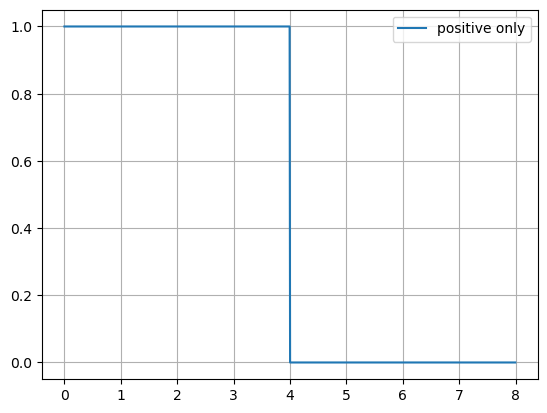

In [38]:
basefrq = 0.125
time_end = 1/basefrq
time_step = time_end/1000
times_smp = np.arange(0, time_end, time_step)
signal_smp = rect_wave(times_smp, basefrq)
plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq),label='positive only')
#plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq,neg=True),'--',label='Alternating')
plt.grid()
plt.legend()

In [39]:
def cnv_trans(basefrq, con_form=False,con8=con8, res0=None,eta=None, tau=None, c=None):
    baseperiod = 1/basefrq
    freq_tau=IPmodel.get_frequency_tau(tau=tau,log2nfreq=20)
    times_tau, data_tau = IPmodel.pelton_fft(con_form=con_form, freq=freq_tau,
            con8=con8,res0=res0,eta=eta,tau=tau, c=c)
    times_tau = times_tau[times_tau <= baseperiod]
    ntime = len(times_tau)
    time_step = times_tau[1] - times_tau[0]
    data_tau = data_tau[:ntime] *time_step
    signal_smp = rect_wave(t=times_tau, basefrq=basefrq)
    obs_smp = np.convolve(signal_smp, data_tau, mode='full')[:ntime]
    return times_tau, obs_smp

In [40]:
def cnv_trans_time(basefrq,time_smp, con_form=False, res0=None,con8=con8,eta=None, tau=None, c=None):
    freq_tau_time =IPmodel.get_frequency_tau_times(tau=tau, times=time_smp)
    times_tau_time, data_tau_time = IPmodel.pelton_fft(con_form=con_form
        , freq=freq_tau_time,con8=con8, res0=res0,eta=eta,tau=tau, c=c)
    time_step = times_tau_time[1] - times_tau_time[0]
    data_tau_time *= time_step
    ntime = len(times_tau_time)
    signal_smp = rect_wave(times_tau_time, basefrq)
    obs_smp = np.convolve(signal_smp, data_tau_time, mode='full')[:ntime]
    window_data = IPmodel.apply_windows(times=times_tau_time, data=obs_smp)
    return window_data #,times_tau_time, obs_smp

In [41]:
res0, eta, tau, c = 0.15, 0.3,  1e-4, 0.8
con8 = 1/(res0*(1-eta))
basefrq = 125 #bfrq_tau*tau*float(ntime)
print(f'basefrq:{basefrq:10.2f}')
time_obs, data_obs = cnv_trans(basefrq=basefrq,
        con_form=False,res0=res0, eta=eta, tau=tau, c=c)
print(len(time_obs), len(data_obs))
hlf = int(len(time_obs))//2
print(f'end   of on-time  res0 {data_obs[hlf-1]:10.2e}')
print(f'start of off-time res8 {data_obs[hlf+1]:10.2e}')
print(f'eta calculated         {(data_obs[hlf+1]/data_obs[hlf-1]):10.2e}')
print(f'eta given              {eta:10.2e}')

basefrq:    125.00
log2(freq) 20.0 considering tau
81921 81921
end   of on-time  res0   1.49e-01
start of off-time res8   4.41e-02
eta calculated           2.95e-01
eta given                3.00e-01


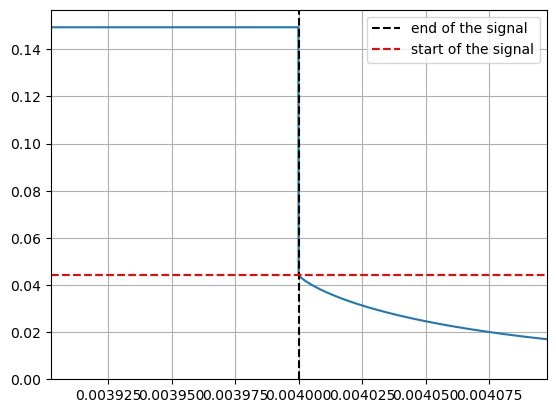

In [42]:
plt.plot(time_obs, data_obs)
plt.axvline(0.5/basefrq, color='k', linestyle='--', label='end of the signal')
plt.axhline(data_obs[-hlf], color='r', linestyle='--', label='start of the signal')
nxzoom = 1000
plt.xlim([time_obs[hlf-nxzoom],time_obs[-hlf+nxzoom]])
plt.ylim(bottom=0)
plt.grid()
plt.legend()

In [43]:
def plot_dcip(basefrq,nxzoom=100,con_form=False
        ,con8=None,res0=None,eta=None,tau=None,c=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(2,1, figsize=(8, 6))
    time_obs, data_obs = cnv_trans(basefrq=basefrq,
        con_form=con_form,con8=con8,res0=res0, eta=eta, tau=tau, c=c)
    hlf = int(len(time_obs))//2
    eta_est = data_obs[hlf+1]/data_obs[hlf-1]
    ntime = len(time_obs)
    ax[0].plot(time_obs, data_obs)
    ax[0].set_title(f'''res0={res0   :10.2e},eta given={eta    :8.3f},  tau={tau:10.2e}, c={c:8.3f}
    bfrq={basefrq:10.2f},eta est  ={eta_est:8.3f},ntime={ntime:8.0f},zoom={nxzoom:8.0f}''')         
    ind_plot = slice(hlf-nxzoom,hlf+nxzoom)
    ax[1].plot(time_obs[ind_plot], data_obs[ind_plot])
    for a in ax:
        a.axvline(0.5/basefrq, color='k', linestyle='--', label='on time end')
        a.axhline(data_obs[-hlf], color='r', linestyle='--', label='amp at start start of decay')
        a.set_ylim(bottom=0)
        a.grid()
        a.legend()

In [44]:
log10bfrqmin, log10bfrqmax = -1, 2
res0_default, eta_default, tau_default, c_default = 0.15, 0.3, 1e-3, 0.8
con8_default = 1 / (res0_default * (1 - eta_default))
basefrq_default = int(1/(tau_default))

In [45]:
#  Widget for the main function
def plot_dcip_widget(basefrq,nxzoom, res0=None, con8=None, eta=None, tau=None, c=None):
    # Use default values if not provided
    res0 = res0 if res0 is not None else res0_default
    con8 = con8 if con8 is not None else con8_default
    eta = eta if eta is not None else eta_default
    tau = tau if tau is not None else tau_default
    c = c if c is not None else c_default
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    plot_dcip(basefrq=basefrq,nxzoom=nxzoom, con_form=False,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

basefrq_slider = ipywidgets.IntSlider(base=10, min=log10bfrqmin, max=log10bfrqmax,
                                        value=basefrq_default, description="Base Frequency")
basefrq_slider = ipywidgets.FloatLogSlider(base=10, min=log10bfrqmin, max=log10bfrqmax, 
                                        value=basefrq_default, description="Base Frequency")
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
nxzoom_slider = ipywidgets.IntSlider(min=10, max=1000, step=10, 
                                  value=100, description="Zoom")

interactive_output_widget = ipywidgets.interactive_output(
    plot_dcip_widget,
    {
        "basefrq": basefrq_slider,
        "res0": res0_slider,
        "con8": con8_slider,
        "eta": eta_slider,
        "tau": tau_slider,
        "c": c_slider,
        "nxzoom": nxzoom_slider,
    }
)
# Display sliders and output
ui = ipywidgets.VBox([
    basefrq_slider, 
    res0_slider, 
    con8_slider, 
    eta_slider, 
    tau_slider, 
    c_slider, 
    nxzoom_slider
])
display(ui, interactive_output_widget)

Output()